# Field rotation

In this tutorial we demonstrate how to rotate a `field` in an arbitrary direction (including multiple consecutive rotations) as well a convenience method to rotate as along principle axis. Rotations can be applied to scalar (`nvdim==1`) and three dimensional vector (`nvdim==3`) fields which exist on a three geometrical dimentional mesh. Periodic boundary conditions are currently not supported (ignored and lost during the rotation process).

The rotation of a field allows for more flexibility:

- cutting planes in arbitrary directions => plots of arbitrary cut planes
- computing integrals along arbitrary direction
- ...

This additional flexibility can be used on its own but is predominantly needed to simulate experiments using `mag2exp`.  However, the limitations of this method need to be taken into account. The result of the rotation is a new `field`, and therefore discretised along (the new) geometric directions. This can introduce a number of numerical (maybe also systematic) errors:

- Remeshing requires to choose a new cell size (done automatically by default). This can introduce errors if either cell size (volume) or the number of cells change. Care from the user is needed to ensure that either change is compatible with the respective use case.
- Interpolation of the `field` values onto the new finite-differences grid introduces additional numerical errors.

In general, multiple consecutive rotations of the same `field` would result in an accumulation of errors. To prevent this we use a special object to rotate the `field`. Consecutive rotations are collected and the actual rotation of a field is always computed starting from the original field.

This tutorial is divided into two parts. In the first part we explain the different methods to rotate a field by looking at a few examples. The second part explains the different steps of the rotation process in more detail.

## Rotating a field

### Original field

Let us first define a field to work with.

In [1]:
import numpy as np

import discretisedfield as df

p1 = (-50, -30, -10)
p2 = (50, 30, 10)
n = (15, 15, 6)
mesh = df.Mesh(p1=p1, p2=p2, n=n)
field = df.Field(mesh, nvdim=3, value=(0, 1, 1), valid="norm")

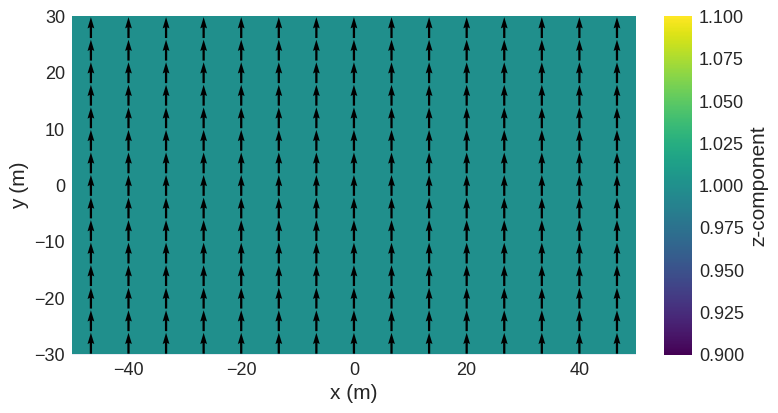

In [2]:
field.sel("z").mpl()

### `rotate90`

Rotations of the `field` by 90 degrees along the principal axis represent a simple case. Thus, we have implemented the dedicated method `rotate90` to reduce computation time and enhance numerical accuracy.
We can specify the names of the spatial dimensions to determine the rotation plane. The rotation direction is from ``ax1`` to ``ax2``.

The `field` can be rotated 90 degrees using in the $xy$ plane.

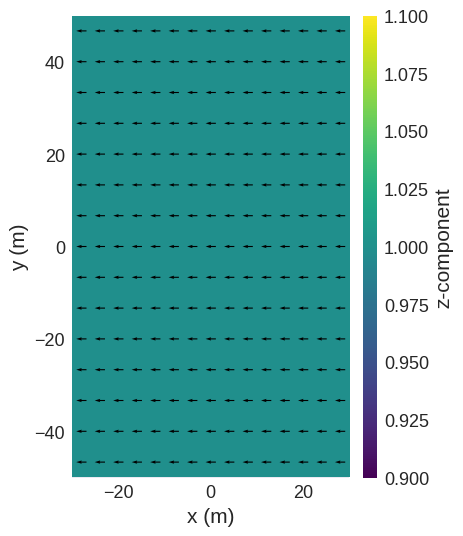

In [3]:
rotated_field = field.rotate90("x", "y")
rotated_field.sel("z").mpl()

It is also possible to specify the number of 90 degree rotations desired using `k`. 
Hence, to perform a 180 degree rotation.

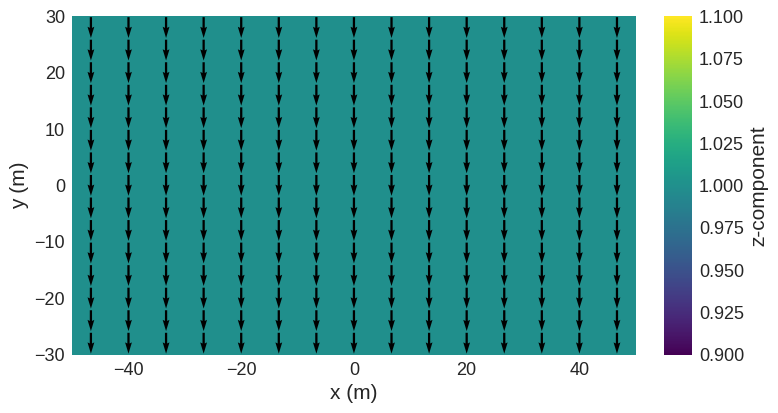

In [4]:
rotated_field = field.rotate90("x", "y", k=2)
rotated_field.sel("z").mpl()

By default, `rotate90` rotates about the center of the region. However, we can also rotate about an arbitrary reference point.

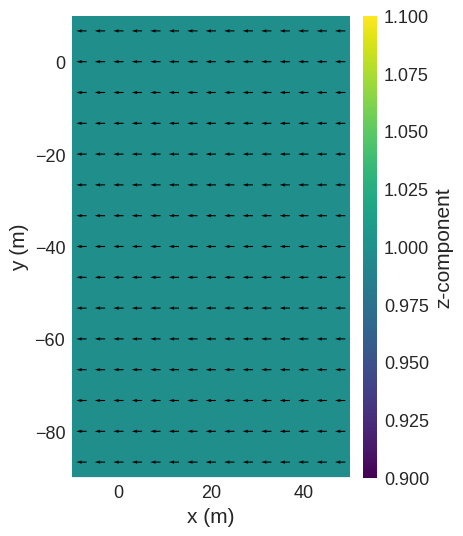

In [5]:
rotated_field = field.rotate90("x", "y", reference_point=(30, -10, 0))
rotated_field.sel("z").mpl()

### `FieldRotator`

Arbitrary rotations of the `field` are handled by a special `FieldRotator` object.

In [6]:
field_rotator = df.FieldRotator(field)

In [7]:
field_rotator

FieldRotator(unrotatedField(Mesh(Region(pmin=[-50, -30, -10], pmax=[50, 30, 10], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[15, 15, 6]), nvdim=3, vdims: (x, y, z)), rotation_quaternion: [0.0, 0.0, 0.0, 1.0])

The `field_rotator` is initialised with an identity rotation matrix (initially no rotation is applied). The rotation matrix is not directly accessible. Instead, it can be modified using the `rotate` method explained in the following.

### Rotation methods

The `field_rotator` can rotate the `field` using the `rotate` method:
```python
field_rotator.rotate
```

Several different methods can be used to specify rotations. Internally, `scipy.spatial.transfom.Rotation` is used to represent and apply rotations. For details on the different methods please refer directly to the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html) of the relevant method. Available methods are:

- `from_quat`
- `from_matrix`
- `from_rotvec`
- `from_mrp`
- `from_euler`

In addition there is the method

- `align_vector`

which is slightly different from the scipy method `align_vectors`. See below for more details on this method.

### Rotations by multiples of 90°

We now show an example using Euler angles to rotate the `field` by 90° around the $x$ axis:

In [8]:
field_rotator.rotate("from_euler", seq="x", angles=np.pi / 2)

The field has now been rotated internally. The rotated field can be accessed as:

In [9]:
# NBVAL_IGNORE_OUTPUT
field_rotator.field

Field(Mesh(Region(pmin=[-50.0, -10.000000000000007, -30.000000000000004], pmax=[50.0, 10.000000000000007, 30.000000000000004], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[15, 6, 15]), nvdim=3, vdims: (x, y, z))

To see the effect of the rotation we can again plot a cross section in the xy-plane. 

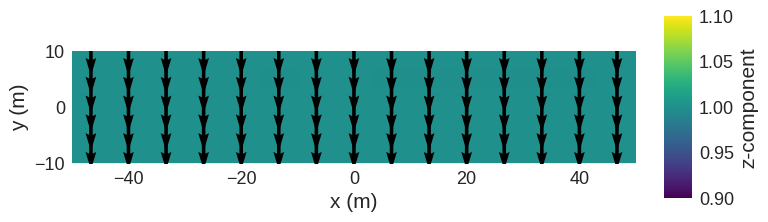

In [10]:
field_rotator.field.sel("z").mpl()

We can now apply a second rotation about the $z$ axis, again by 90°. For demonstration purposes we use a different method `'from_rotvec'`. We have to pass a vector that specifies the rotation axis and whose norm gives the angle of rotation.

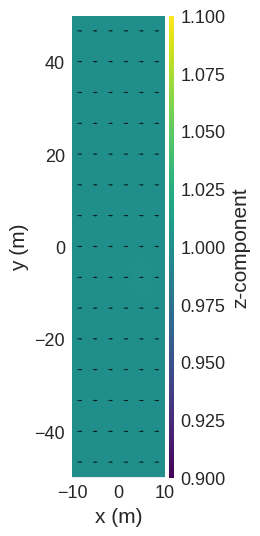

In [11]:
field_rotator.rotate("from_rotvec", [0, 0, np.pi / 2])
field_rotator.field.sel("z").mpl()

It is possible to clear all rotations.

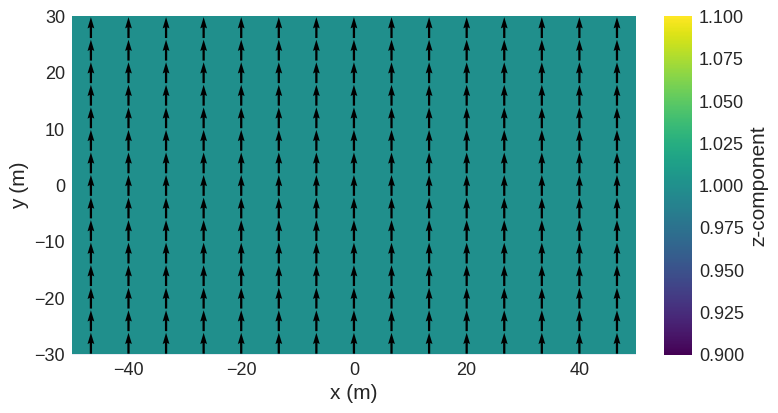

In [12]:
field_rotator.clear_rotation()
field_rotator.field.sel("z").mpl()

### Rotations about arbitrary angles

We can rotate the field about an arbitrary angle. To keep this section simple we only show rotations about the z-axis that can be easily visualised on as single plane.

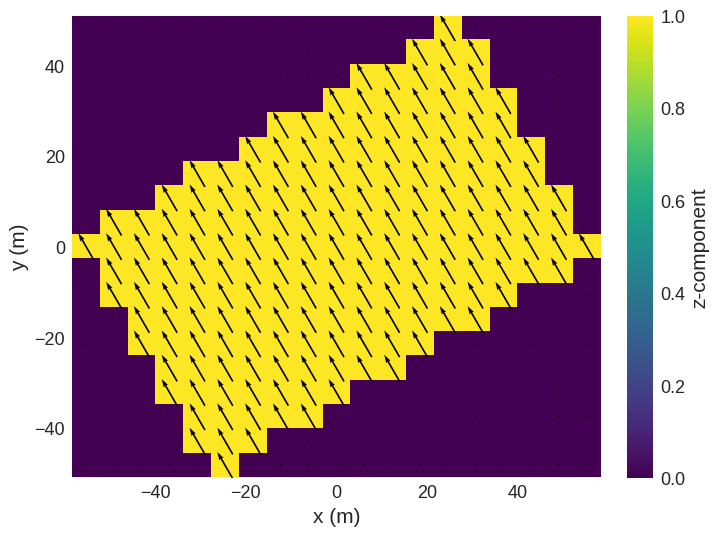

In [13]:
field_rotator.rotate("from_euler", seq="z", angles=np.pi / 6)
field_rotator.field.sel("z").mpl()

The rotated field can be seen to have jagged edges caused by the discretisation of the mesh. The number of cells has also changed compared to the original field.

In [14]:
field.mesh.n

array([15, 15,  6])

In [15]:
field_rotator.field.mesh.n

array([19, 19,  8])

Note that the number of cells did also change along the rotation axis. The reason for this is the normalisation of the cell volume of the rotated mesh.

We can see that the rotation results in a larger region. We can again combine multiple rotations. The region is maximised if we rotate about 45° in total.

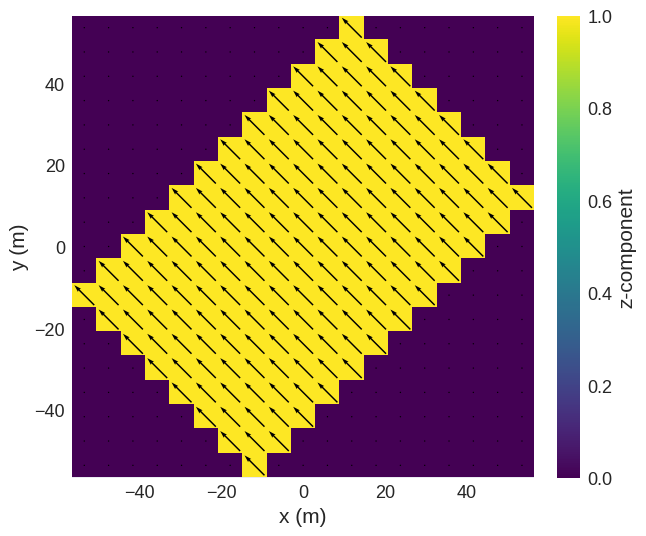

In [16]:
field_rotator.rotate("from_euler", seq="z", angles=np.pi / 12)
field_rotator.field.sel("z").mpl()

In [17]:
field_rotator.clear_rotation()

The rotation is achieved by linear interpolation of the rotated object from the old mesh into the new mesh. We can change the number of discretisation cells in the new mesh by passing `n` to the rotate function.

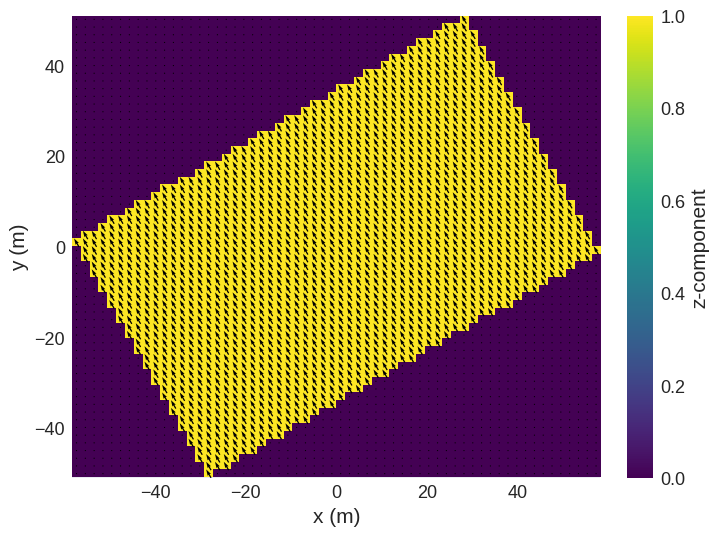

In [18]:
field_rotator.rotate("from_euler", seq="z", angles=np.pi / 6, n=(60, 60, 20))
field_rotator.field.sel("z").mpl()

### Rotating a vector to point in a certain direction
Sometimes it is convenient to specify a certain vector in the old and new coordinate system instead of specifying a rotation axis and an angle. This can be achieved with the method `align_vector`. Two vectors `initial` and `final` have to be specified and the rotation rotates the vector `inital` to the vector `final`. The cross product is kept fixed and hence defines the rotation axis.

To give an example, we can rotate one of the corners to point in the z-direction. We start with removing all rotations.

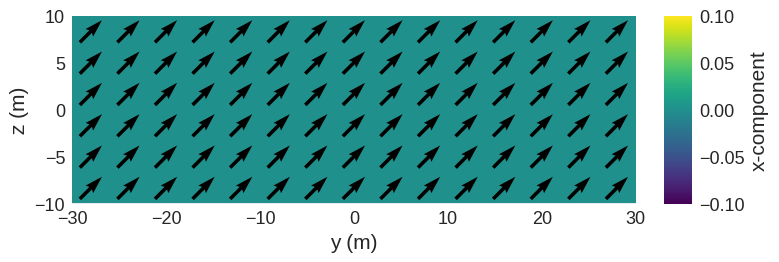

In [19]:
field_rotator.clear_rotation()
field_rotator.field.sel("x").mpl()

We choose vector `initial=(5, 3, 1)` pointing to the point `pmax`

In [20]:
field.mesh.region.pmax

array([50, 30, 10])

We want this vector to point along `final=(0, 0, 1)` direction after applying the rotation.

In [21]:
field_rotator.rotate("align_vector", initial=(5, 3, 1), final=(0, 0, 1))

Using matplotlib we can plot one cut plane:

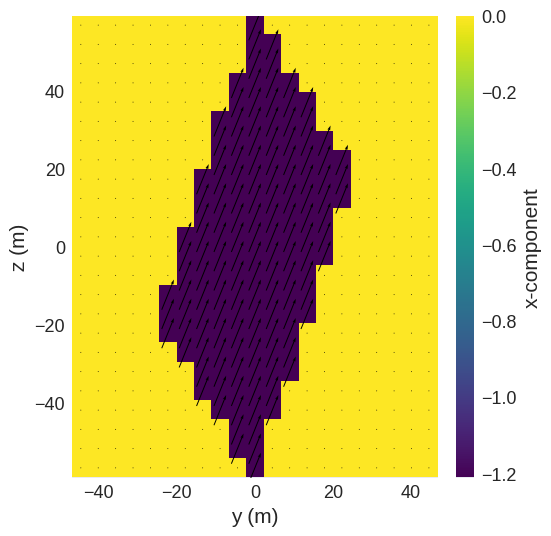

In [22]:
field_rotator.field.sel("x").mpl()

As mentioned in the introduction, we can compute arbitrary quantities using the rotated field. As illustrative example we compute the integral along the new $x$ axis and plot the result. After computing the integral we can see the original rectangular shape of the field.

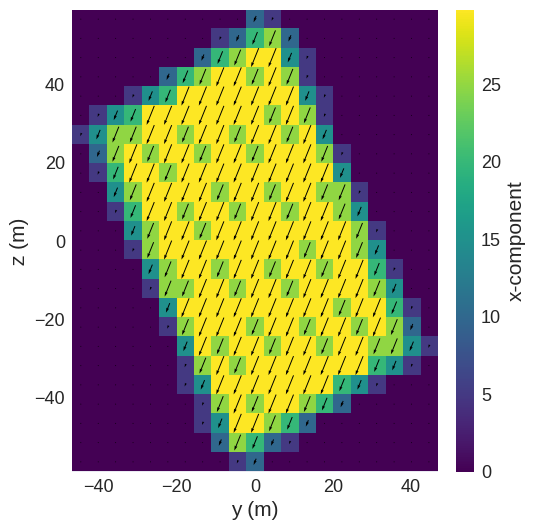

In [23]:
rfield = field_rotator.field
(-rfield).integrate("x").mpl()

We can see the smaller integral values near the boundaries that are related to a reduced number of cells in these regions. We can also see some additional stripe-like features in the inner area that are related to numerical inaccuracies.

## Details of the rotation process

The rotation of a `field` can be separated into three different processes:

1. rotation of the `region`
2. rotation of the `mesh`
3. rotation of the `field` values

We discuss these processes in greater detail in the following subsections.

### 1. Rotation of the region

The first step of the rotation procces is rotation of the region. The rotated initial region is in general not anymore aligned with the coordinate axes. We need a new aligned region fully enclosing the rotated initial region. Therefore, this new region must be larger than the unrotated inital region in order to fully enclose the rotated initial region. The required size is obtained by rotating the three vectors pointing along the edges of the old region in $x$, $y$, and $z$ direction. Then, the $x$, $y$, and $z$ components of these rotated vectors in the new coordinate system are summed up to obtain the new edge lengths.

The rotation in two dimensions is shown in the following figure. The original field is show in red, the region size for different rotations (0°, 15°, 45°, 60°) in blue.

![Rotation in 2d](figures/rotation_region.svg)

In this example of a quadratic field the new region grows the most for a 45° rotation. The implementation of `FieldRotator` ensures that the new region is as small as possible by accumulating and combining all rotation operations and computing the rotated field always directly from the initial unrotated field. However, the norm of the original field is not taken into account, i.e. only the size of the old region is important not the actual area containing data.

As an example, to make this clearer, we show the rotation of a field where non-zero values are inside a disk. In princible, this field would not need a larger region to be rotated. However, as only the region is taken into account, the new region is larger than theoretically needed.

![Rotation of a disk (non-zero part of the field) do demonstrate limitations](figures/rotation_disk.svg)

### 2. Rotation of the mesh

The second step of the rotation process is the rotation of the mesh. Since we already have the new region, this is basically the rotation of a cell to determine the new cell size/number of cells. This can be either done automatically or manually.

If the new number of cells is either known or certain values are needed the user can specify an additional argument `n` in the `rotate` method to specify the number of cells in $x$, $y$, and $z$ direction:
```
field_rotator.rotate(..., n=(<nx>, <ny>, <nz>), ...)
```

By default `n=None` and the new cell size is determined automatically.

1. A single cell of the old mesh is rotated similarly to how the region is rotated.
2. The new cell is resized to have the same volume as the old cell (the aspect ratio of the new cell is fixed).
3. The number of cells in the new region is determined from the new region and cell size. Generally, we obtain non-integer cell numbers as a consequence of the cell resizing.
4. The obtained cell numbers are rounded to the nearest integer value. Therefore, the cell volume is only aproximately keep constant.


### 3. Rotation of the field values

The last part of the rotation process is the rotation of the `field` values. This consists of two parts:

1. Rotation of the field values (for vector fields only)
2. Interpolation of the values on the new mesh

The first step is only required for vector fields. The field values, i.e. the vector in each cell in the old mesh is rotated. This is only supported for 3d vector fields (`field.dim==3`).

The second step is the mapping of the (rotated) field components onto the new rotated mesh. This is done by taking the cell positions of the new mesh, rotating them back to the old mesh, and then linearly interpolating the (rotated) field values on the old mesh to determine the field values at the new cell positions.